<a href="https://colab.research.google.com/github/patrickctrf/ia376-paula/blob/l2/L2/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
import torch

random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

from matplotlib import pyplot as plt

img_dim = 28


def show_img(img):
    img = img.permute(1, 2, 0)
    if img.shape[2] == 1:
        img = img.view(img.shape[0], img.shape[1])
    plt.title(f'Image has size {img.cpu().numpy().shape}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install ptk-patrickctrf

In [ ]:
from torchvision import transforms, datasets

transforms_all = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    # transforms.RandomCrop((20, 20)),
    transforms.Resize(size=(img_dim, img_dim)),
    transforms.ToTensor()
])

transforms_tensor = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
from torch.utils.data import Subset

dataset = datasets.MNIST(root="./datasets", train=True, transform=transforms_all, download=True)

# Split into train and validation
train_dataset = Subset(dataset, range(0, 6000))
val_dataset = Subset(dataset, range(6000, len(dataset)))

test_dataset = datasets.MNIST(root="./datasets", train=False, transform=transforms_tensor, download=True)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=1)

Batch shape:  torch.Size([1024, 1, 28, 28])


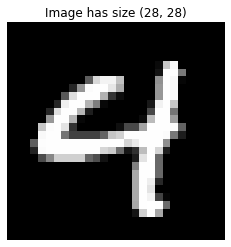

In [ ]:
for batch in train_dataloader:
    print("Batch shape: ", batch[0].shape)
    original_image = batch[0][0]
    show_img(original_image)
    # show_img(transforms_all(transforms.ToPILImage()(original_image)))
    break

In [ ]:
from torch import nn


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        z_dim = 8  # Dimensão do espaço latente

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_dim * img_dim, 1024),  # Entra imagem 28x28, sai um vetor de 1024 elementos
            nn.Tanh(),
            nn.Linear(1024, z_dim),
        )

        self.mean_layer = nn.Linear(z_dim, z_dim)
        self.var_layer = nn.Linear(z_dim, z_dim)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.Tanh(),
            nn.Linear(1024, img_dim * img_dim),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.mean_layer(h1), self.var_layer(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        # don't forget forward pass re-index

        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:

def loss_function(recon_x, x, mu, logvar):
    bce = torch.nn.functional.binary_cross_entropy(recon_x.view(-1, 28 * 28), x.view(-1, 28 * 28), reduction='sum')

    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return bce + kld

In [ ]:
from ptk import DataManager
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast

max_examples = 3000000
eval_every_steps = 500
lr = 1e-4
use_amp = False

model = VAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, min_lr=1e-5, patience=500, threshold=1e+2, verbose=True)
scaler = GradScaler()


def train_step(x, ):
    model.train()
    model.zero_grad()
    with autocast(enabled=use_amp):
        x_hat, mu, logvar = model(x)
        loss = loss_function(x_hat, x, mu, logvar)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    return loss.item()


def validation_step(x, ):
    model.eval()
    with autocast(enabled=use_amp):
        x_hat, mu, logvar = model(x)
        loss = loss_function(x_hat, x, mu, logvar)
    return loss.item()


best_validation_loss = 999999999
train_losses = []
n_examples = 0
step = 0
pbar = tqdm(total=max_examples)
while n_examples < max_examples:
    for imgs, target_class in DataManager(train_dataloader, device=device, buffer_size=10, data_type=None):
        loss = train_step(imgs.to(device), )
        train_losses.append(loss)

        # LR scheduler
        scheduler.step(loss)

        if step % eval_every_steps == 0:
            train_loss = np.average(train_losses)

            with torch.no_grad():
                valid_loss = np.average([
                    validation_step(val_imgs.to(device), )
                    for val_imgs, val_target_classes in DataManager(val_dataloader, device=device, buffer_size=10, data_type=None)])
                # Checkpoint to best models found.
                if best_validation_loss > valid_loss:
                    # Update the new best perplexity.
                    best_validation_loss = valid_loss
                    model.eval()
                    torch.save(model, "best_model.pth")

            print(f'{step} steps; {n_examples} examples so far; train loss: {train_loss:.2f}, valid loss: {valid_loss:.2f}')
            train_losses = []

        n_examples += len(imgs)  # Increment of batch size
        step += 1
        pbar.update(len(imgs))
        if n_examples >= max_examples:
            break

pbar.close()

# Restore best model (checkpoint) found
model = torch.load("best_model.pth")

  0%|          | 1024/3000000 [00:02<1:38:38, 506.67it/s]

0 steps; 0 examples so far; train loss: 564414.38, valid loss: 556185.04


 17%|█▋        | 498000/3000000 [00:35<02:28, 16822.43it/s]

Epoch 00501: reducing learning rate of group 0 to 5.0000e-05.


 17%|█▋        | 501072/3000000 [00:37<09:41, 4299.94it/s] 

500 steps; 500048 examples so far; train loss: 204000.06, valid loss: 163543.08


 33%|███▎      | 1001120/3000000 [01:14<06:46, 4914.23it/s]

1000 steps; 1000096 examples so far; train loss: 154710.91, valid loss: 155781.42
Epoch 01002: reducing learning rate of group 0 to 2.5000e-05.


 50%|█████     | 1502048/3000000 [01:51<05:35, 4462.24it/s] 

1500 steps; 1500000 examples so far; train loss: 149636.86, valid loss: 152918.32
Epoch 01503: reducing learning rate of group 0 to 1.2500e-05.


 67%|██████▋   | 2001072/3000000 [02:28<03:58, 4188.41it/s] 

2000 steps; 2000048 examples so far; train loss: 147542.28, valid loss: 151533.50
Epoch 02004: reducing learning rate of group 0 to 1.0000e-05.


 83%|████████▎ | 2501120/3000000 [03:05<01:50, 4514.38it/s] 

2500 steps; 2500096 examples so far; train loss: 146265.72, valid loss: 150414.99


100%|██████████| 3000000/3000000 [03:39<00:00, 13656.97it/s]


Original image: 


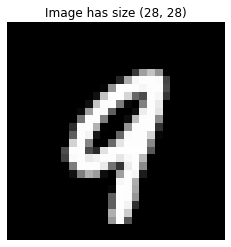

Reconstructed image: 


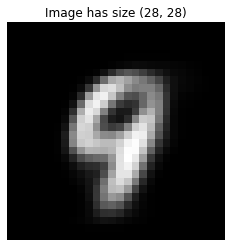

Encoded img:  tensor([[-3.1128, -0.2040, -3.0309,  5.3066,  1.3712, -0.8655,  0.6061, -5.5351]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
for imgs, classes in test_dataloader:
    imgs_hat = model(imgs.to(device))
    print("Original image: ")
    show_img(imgs[0])
    print("Reconstructed image: ")
    show_img(imgs_hat[0][0].cpu().detach())
    print("Encoded img: ", model.encoder(imgs.to(device)))
    break


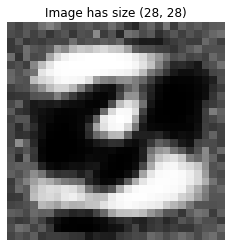

In [ ]:
z = torch.tensor([[-0.1, 1.4, -4.4, -0.5, 0.3, -5.1, -1.5, 0.2]]).to(device)

show_img(model.decode(z).view(1, 28, 28).cpu().detach())

In [ ]:
# print("mu: ", mu)
# print("logvar: ", logvar)
# print("z: ", z)

# mu, logvar = model.mean_layer(torch.tensor([[-3.1128, -0.2040, -3.0309,  5.3066,  1.3712, -0.8655,  0.6061, -5.5351]]).to(device)), model.var_layer(torch.tensor([[ 4.4,  5.2, -0.4, -4.3,  2.4,  2.6,  1.0, -3.0]]).to(device))
# z = model.reparameterize(mu, logvar)


# mu = torch.tensor([[-0.6430,  0.3323,  3.0516, -0.2617,  0.2254, -0.8837, -1.1234, -0.2685]]).to(device)
# logvar = torch.tensor([[-1.1355,  1.7364,  1.7175,  2.5520, -1.7615,  1.1535, -0.2506,  0.4210]]).to(device)